# Calculs d'indicateurs journaliers pour les données hmvl DIRMED
## 0. Initialisation

In [1]:
import pandas as pd
import matplotlib
import psycopg2
import arrow
import numpy as np

In [3]:
import scriptindic as scr

In [3]:
host="localhost"
port=5432
dbname="hmvl"
username="dirmed"
#pwd="votremotdepasse"
# à remplacer par votre de mot de passe et surtout ne pas publier en ligne!!!

In [3]:
LABOCOM=['MBS','MPH','MPB','MPA','MPG','MPF','MBO']

## 1. Lecture des données hmvl pour une journée

## 1.1. Lecture en base postgres

In [4]:
hmvl=scr.lirejourhmvl("2020-04-26",host,port,dbname,username,pwd)

In [5]:
hmvl

,hdt,station,status,voie,vitesse,longueur,statuttr
0,2020-04-26 23:59:58.520000+02:00,MPA,NaN,2,87.0,17.000000,@
1,2020-04-26 23:59:50.620000+02:00,MPG,NaN,2,126.0,3.900000,B
2,2020-04-26 23:59:30.800000+02:00,MBS,NaN,2,78.0,16.900000,@
3,2020-04-26 23:59:19.170000+02:00,MPH,NaN,2,91.0,17.200001,B
4,2020-04-26 23:59:00.450000+02:00,MBO,NaN,2,85.0,3.600000,@
...,...,...,...,...,...,...,...
1583790,2020-04-26 00:00:30.960000+02:00,MBS,NaN,2,125.0,4.100000,@
1583791,2020-04-26 00:00:16.430000+02:00,MPH,NaN,2,86.0,11.400000,B
1583792,2020-04-26 00:00:07.180000+02:00,MPA,NaN,0,118.0,3.500000,@
1583793,2020-04-26 00:00:00+02:00,MPG,NaN,NaN,NaN,NaN,B


## 1.2 lecture d'un fichier csv pour une journée

In [4]:
# à remplacer par votre nom de fichier!
nomcsv='/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/2020-07-22.csv'
hmvl=scr.lirecsvhmvl(nomcsv)

2020-09-04 11:34:22.465136
2020-09-04 11:34:54.668047 après lecture du csv


## 2. Calcul d'indicateurs par station et par heure pour un jour donné

In [6]:
# indicateurs : nbmes, nbmes_vitesse, nbmes_longueur, nb_status2, nb_status1, nb_status34, 
#               nb_sansvoie, nb_l_aberr, nb_v_aberr
# création d'un dataframe d'indicateurs qualité, exportable ensuite en CSV et/ou en BD postgres
# seuils de longueurs et vitesse aberrantes "en dur", et à revoir. 
# Notamment, peut être ne PAS mettre de longueur MIN 
Lmin=0.5
Lmax=25.0
Vmax=240.0


In [ ]:
qualite=scr.indicqualite(hmvl)

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [6]:
qualite

,station,heure,nb_mes,nb_mesvit,nb_meslong,nb_status2,nb_status1,nb_status34,nb_sansvoie,nb_l_aberr,nb_v_aberr,taux_fichierRD6sec_absent
0,M1B,2020-07-22 00:00,642,91.90,91.90,2.65,5.30,0.0,7.94,0.00,0.0,52.17
1,M1B,2020-07-22 01:00,668,91.77,91.77,2.10,5.84,0.0,7.93,0.00,0.0,47.83
2,M1B,2020-07-22 02:00,971,80.74,80.74,3.91,15.35,0.0,19.26,0.00,0.0,2.17
3,M1B,2020-07-22 03:00,748,62.30,62.30,7.09,30.61,0.0,37.70,0.00,0.0,0.17
4,M1B,2020-07-22 04:00,668,40.57,40.57,13.77,45.66,0.0,59.43,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3523,MPH,2020-07-22 19:00,2285,72.69,72.69,0.00,0.00,0.0,0.00,0.39,9.0,NaN
3524,MPH,2020-07-22 20:00,1553,72.50,72.50,0.00,0.00,0.0,0.00,0.26,4.0,NaN
3525,MPH,2020-07-22 21:00,1072,74.25,74.25,0.00,0.00,0.0,0.00,0.37,4.0,NaN
3526,MPH,2020-07-22 22:00,886,71.44,71.44,0.00,0.00,0.0,0.00,0.23,2.0,NaN


## 2B. TESTS d'ALERTES SUR LES INDICATEURS

In [12]:
# on utilise la fonction alertes qui part d'un dataframe q produit par indicqualite
# en 1ere approche la fonction affiche pour chaque type d'alerte la liste des stations en alerte
# on calcule les alertes sur la base de valeurs moyennes des taux de défaut par heure et de seuils pour ces valeurs
# d'autres méthodes de calcul sont possibles bien sûr



In [15]:
scr.alertes(qualite)

Stations avec taux moyen de status2 > 50% :['M3z', 'M3c', 'M3v', 'M3C', 'M4o', 'M4h', 'M3O', 'M4j', 'M3N', 'M7j', 'M7J', 'M1E', 'M4e', 'M4i', 'M4k', 'M7q', 'M3w', 'M3S', 'M3k', 'M8Q', 'M7Q', 'M3b', 'M3L', 'M4c', 'M1e', 'M5r']
Stations avec taux moyen de status1 > 50% :['M8G', 'M1c', 'M8a', 'MPG']
Stations avec taux moyen de mesures sans valeurs (L, V, voie) > 50% :['M8G', 'M1c', 'M8a', 'MPG']
Stations avec taux moyen de vitesses aberrantes (240km/h) > 2% :['M1d', 'M3P', 'MPH', 'M1G', 'M3r']


KeyError: 'Column not found: taux_fichiersRD6sec_absents'

## 3. Calcul des données 6 minutes pour 1 jour, à partir d'un dataframe hmvl

In [7]:
moy6=scr.agreg6(hmvl)


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/hmvl/scriptindic.py:195: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  moy6=x.groupby(['station'])['longueur','invvit'].resample('6Min').mean()


In [8]:
moy6

l6      v6   q6
station hdt                                         
M1B     2020-07-22 00:30:00+02:00  3.96   89.09  115
        2020-07-22 00:36:00+02:00  4.27   91.33  132
        2020-07-22 00:42:00+02:00  4.10   91.71  109
        2020-07-22 00:48:00+02:00  3.91   94.05  126
        2020-07-22 00:54:00+02:00  4.01   94.46  102
...                                 ...     ...  ...
MPH     2020-07-22 23:30:00+02:00  9.07  100.30   46
        2020-07-22 23:36:00+02:00  9.26   98.91   57
        2020-07-22 23:42:00+02:00  8.79   99.50   52
        2020-07-22 23:48:00+02:00  6.95  102.14   41
        2020-07-22 23:54:00+02:00  7.82  102.08   43

[26508 rows x 3 columns]

## 4. Calcul des temps et distances intervéhiculaires

In [ ]:
# calcul des temps et distances inter-véhiculaires par heure, par voie et par station
# le calcul passe par une fonction intermédiaire tiv qui ajoute 1 colonne TIV et une colonne DIV au dataframe hmvl
# il est bien sûr possible d'appeler cette fonction pour avoir le détail des TIV et DIV : x=tiv(hmvl)

In [9]:
tdiv1H=scr.agregtdiv1H(hmvl)

/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/hmvl/scriptindic.py:172: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tdiv1H=x.groupby(['station','voie'])['tiv','div'].resample('1H').mean()
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [10]:
tdiv1H

,station,voie,heure,tiv,div
0,M1B,0,2020-07-22 00:00,6.66,164.30
1,M1B,0,2020-07-22 01:00,7.04,175.34
2,M1B,0,2020-07-22 02:00,16.39,448.16
3,M1B,0,2020-07-22 03:00,21.77,567.12
4,M1B,0,2020-07-22 04:00,41.40,1032.40
...,...,...,...,...,...
9438,MPH,3,2020-07-22 19:00,13.33,442.58
9439,MPH,3,2020-07-22 20:00,20.81,689.04
9440,MPH,3,2020-07-22 21:00,31.80,1019.39
9441,MPH,3,2020-07-22 22:00,51.33,1680.37


## 5. Stockage des indicateurs


In [249]:
# le stockage en base n'est pas jugé utile


In [250]:
scr.ecrireagreg6(moy6,pwd)
# écriture en base pg, fonction obsolète

In [275]:
def tocsv(m,file):
	# fonction écrivant les données agrégées 6' en base : en entrée dataframe q produit par la fonction indicqualite
	#                                                      ou dataframe m produit par la fonction agreg6
	#   et nom du fichier
	# suppose qu'existe la table moy6 avec le même schéma (colonnes)
	# pour l'instant l'horodate est encodée comme une string en base
	m=m.reset_index()
	m.to_csv(path_or_buf=file, index=False)


In [12]:
scr.tocsv(qualite,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/q2207.csv')

In [14]:
scr.tocsv(moy6,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/m2207.csv')


In [ ]:
scr.tocsv(tdiv1H,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/tdiv2207.csv')

## 7. Affichage de cartes. tests geopandas référentiel des stations SRDT

In [46]:
# conda install geopandas comme préalable (dans l'env hmvl : conda activate hmvl)
import geopandas
import contextily as ctx

In [47]:
srdt=geopandas.read_file('ressources/SRDT_DIRMed.shp')
ref=pd.read_csv('ressources/pointsdemesure.csv')
# il y a 279 points de mesure dans le fichier CSV de référence, chacun avec un nom unique (codePM ou codeSOL2)
# dans le shapefile SRDT il y a 237 entrées alors que ça couvre toute la DIR et pas seulement le district urbain, 
# et il y a des doublons (234 valeurs uniques du champ IdNat qui contient à la fois des codes PM et des codes MISOL2)
# il faudra récupérer des données plus propres
# dans un 1er temps on prend les données comme elles sont

In [48]:
srdt=srdt[['objetID','route','idNat','commentair','geometry']]
ref=ref[['Code PM','Libellé','PR début','PR fin','Sens','Axe','Code MISOL2']]

In [49]:
srdt=srdt.rename(columns={"objetID": "ID", "route": "axe", 'idNat': "PM", "commentaire":"nom"})
ref=ref.rename(columns={"Code PM": "PM", "Libellé": "infos", "PR début":"PRD", "PR fin":"PRF", 'Code MISOL2':'SOL2'})
sol2pm=dict(zip(ref.SOL2,ref.PM))

In [45]:
sol2pm

{'MM413.C': 'M4C',
 'MM413.D': 'M4D',
 'MM413.E': 'M4E',
 'MM413.F': 'M4F',
 'MM413.G': 'M4G',
 'MM413.c': 'M4c',
 'MM413.d': 'M4d',
 'MM413.e': 'M4e',
 'MM413.f': 'M4f',
 'MM413.g': 'M4g',
 'MM413.K': 'M4K',
 'MM413.L': 'M4L',
 'MM413.M': 'M4M',
 'MM413.N': 'M4N',
 'MM413.O': 'M4O',
 'MM413.k': 'M4k',
 'MM413.l': 'M4l',
 'MM413.m': 'M4m',
 'MM413.n': 'M4n',
 'MM413.o': 'M4o',
 'MM413.H': 'M4H',
 'MM413.I': 'M4I',
 'MM413.J': 'M4J',
 'MM413.h': 'M4h',
 'MM413.i': 'M4i',
 'MM413.j': 'M4j',
 'MM113.A': 'M1A',
 'MM113.B': 'M1B',
 'Mm113.B': 'm1B',
 'MM113.C': 'M1C',
 'MM113.D': 'M1D',
 'MM113.E': 'M1E',
 'MM113.F': 'M1F',
 'Mm113.F': 'm1F',
 'MM113.G': 'M1G',
 'MM113.H': 'M1H',
 'MM113.I': 'M1I',
 'MM113.J': 'M1J',
 'MM113.L': 'M1L',
 'MM113.M': 'M1M',
 'MM113.O': 'M1O',
 'MM113.Q': 'M1Q',
 'MM113.S': 'M1S',
 'MM113.T': 'M1T',
 'MM113.Y': 'M1Y',
 'MM113.a': 'M1a',
 'MM113.b': 'M1b',
 'MM113.c': 'M1c',
 'MM113.d': 'M1d',
 'MM113.e': 'M1e',
 'Mmb13.e': 'mbe',
 'MM113.f': 'M1f',
 'Mmb13.f': 

In [53]:
srdt=pd.merge(srdt,ref,on=['PM'],how='inner')
# on fait une jointure sur les PM présents dans SRDT (qui est notre référence pour les coordonnées des stations) 
#   et dans ref (qui est notre référence pour les données hmvl)
# on voit qu'il ne reste que 168 points (sur 279!)

In [52]:
for i in range(len(srdt['PM'])):
    #print (i)
    j=srdt['PM'].iloc[i]
    #print(j)
    if j not in ref['PM'].to_list():
        if j not in sol2pm:
            print (j+" présent dans shapefile srdt et pas dans le réf csv")
        else:
            srdt['PM'].iloc[i]=sol2pm[srdt['PM'].iloc[i]]

In [60]:
srdt=srdt.to_crs(epsg=3857)
# voir https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

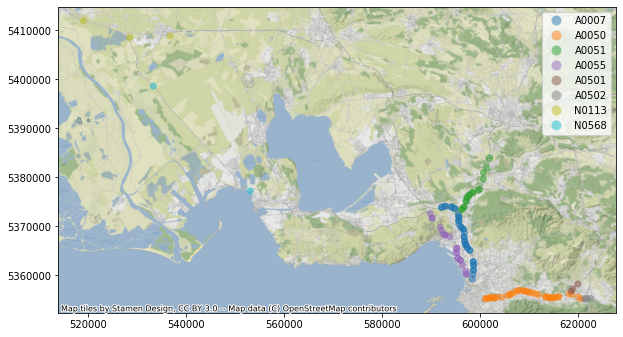

In [61]:
ax = srdt.plot(figsize=(10, 10), alpha=0.5, column='axe',legend=True)
# couleur selon l'axe, il manque L2
ctx.add_basemap(ax,zoom=13)

In [14]:
srdt

,ID,axe,PM,commentair,geometry,infos,PRD,PRF,Sens,Axe,SOL2
0,DIRMED_SRDT_000119,A0007,M7I,Agavon_Tr,POINT (884698.002 6259859.435),PME_A7_1_264+687_M7I,264+687,265+187,1,A7,MM713.I
1,DIRMED_SRDT_000121,A0007,M7J,L_ANJOLY,POINT (885065.662 6259489.631),PME_A7_1_265+320_M7J,265+320,265+820,1,A7,MM713.J
2,DIRMED_SRDT_000122,A0007,M7N,LES_PENNES_MIR,POINT (886908.352 6258773.111),PME_A7_1_267+230_M7N,267+230,267+730,1,A7,MM713.N
3,DIRMED_SRDT_000124,A0007,M7O,A55_LES_PENNES,POINT (887531.570 6258833.916),PME_A7_1_267+861_M7O,267+861,268+361,1,A7,MM713.O
4,DIRMED_SRDT_000126,A0007,M7P,None,POINT (887950.220 6258980.552),PME_A7_1_268+288_M7P,268+288,268+788,1,A7,MM713.P
...,...,...,...,...,...,...,...,...,...,...,...
163,DIRMED_SRDT_000172,N0568,MPF,None,POINT (859489.837 6260638.948),PME_RN568_25+350_1_MPF,25+350,26+350,1,N568,MMP13.F
164,DIRMED_SRDT_000168,N0568,MPF,Fos PMV,POINT (855764.954 6263993.900),PME_RN568_25+350_1_MPF,25+350,26+350,1,N568,MMP13.F
165,DIRMED_SRDT_000208,N0568,MBO,Fos Est N568,POINT (859477.063 6260641.631),PME_RN568_30+980_1_MBO,30+980,31+800,1,N568,MMB13.O
166,DIRMED_SRDT_000173,N0568,MPG,None,POINT (844766.462 6275767.152),PME_RN568_9+250_1_MPG,9+250,10+250,1,N568,MMP13.G
